# FocusedCap Inference Notebook

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init

import heapq
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd

from TranSalNet_Res import TranSalNet
from utils.data_process import preprocess_img
from utils.CombinedTokenizer import FCTokenizer
import math


In [14]:
MODEL_NUMBER = 5 # select model number (put either 5, or -1)
prefix = "coco_newer" # select model (if pre-finetuned put "coco_newer", or put "fine_tune" for finetuned model)
VOCAB_SIZE = 30_000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
START_ID = 2
STOP_ID = 3
MAX_LEN = 20
HIDDEN_SIZE = 512
tokeniser = FCTokenizer("./data/tokenizer_coco2014_vg.json")


In [25]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Load saliency prediction model TranSalNet
        self.saliency = TranSalNet()
        self.saliency.load_state_dict(torch.load('pretrained_models/TranSalNet_Res.pth', map_location=device))
        self.saliency.to(device)
        # self.saliency.eval()

        # Freeze model parameters
        for param in self.saliency.parameters():
            param.requires_grad = False
        
        # Convolutional layer with Glorot Initialisation, ReLu activation
        self.conv1x1 = nn.Conv2d(2048, 512, kernel_size=1)
        init.xavier_normal_(self.conv1x1.weight)
        init.zeros_(self.conv1x1.bias)

    def forward(self, img):
        with torch.no_grad():
            feat = self.saliency.encoder(img)[-1]
            sal = self.saliency(img) # (1, 1, 288, 384)
        feat = self.conv1x1(feat)
        feat = F.relu(feat)
        sal = F.avg_pool2d(sal, (32, 32), stride=(32, 32))
        sal = (sal - torch.min(sal)) / (torch.max(sal) - torch.min(sal))
        return sal, feat # (1, 1, 9, 12), (1, 512, 9, 12)

class SalCtxAttention(nn.Module):
    def __init__(self, feature_dim, hidden_dim):
        super(SalCtxAttention, self).__init__()
         # Attention weights as suggested in https://arxiv.org/pdf/1706.08474.pdf
        self.W_a_sal = nn.Linear(feature_dim, feature_dim)
        self.W_h_sal = nn.Linear(hidden_dim, feature_dim)
        self.V_sal = nn.Linear(feature_dim, 1)

        self.W_a_ctx = nn.Linear(feature_dim, feature_dim)
        self.W_h_ctx = nn.Linear(hidden_dim, feature_dim)
        self.V_ctx = nn.Linear(feature_dim, 1)

        self.softmax = nn.Softmax(dim=1)

        # Weight initialisations
        init.xavier_normal_(self.W_a_sal.weight)
        init.xavier_normal_(self.W_a_ctx.weight)
        init.xavier_normal_(self.W_h_sal.weight)
        init.xavier_normal_(self.W_h_ctx.weight)

        init.zeros_(self.W_a_sal.bias)
        init.zeros_(self.W_a_ctx.bias)
        init.zeros_(self.W_h_sal.bias)
        init.zeros_(self.W_h_ctx.bias)
        init.zeros_(self.V_sal.bias)
        init.zeros_(self.V_ctx.bias)
        init.zeros_(self.V_sal.weight)
        init.zeros_(self.V_ctx.weight)
    
    def forward(self, features, hidden_state, sal, ctx):
        e_sal = self.V_sal(torch.tanh(self.W_a_sal(features) + self.W_h_sal(hidden_state)))
        e_ctx = self.V_ctx(torch.tanh(self.W_a_ctx(features) + self.W_h_ctx(hidden_state)))
        a_score = e_sal * sal + e_ctx * ctx
        a_weights = self.softmax(a_score)
        return a_weights, torch.mean(e_sal), torch.mean(e_ctx)

class Decoder(nn.Module):
    def __init__(self, embedding_size=512, feature_dim=512, hidden_size=512, vocab_size=30_000, momentum=0.9):
        super(Decoder, self).__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        input_size = feature_dim + embedding_size
        self.feature_dim = feature_dim
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.attention = SalCtxAttention(feature_dim=feature_dim, hidden_dim=hidden_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout =nn.Dropout(p=0.5)
        self.bn = nn.BatchNorm1d(num_features=hidden_size, momentum=momentum, affine=True)
        self.fc0 = nn.Linear(hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Initialise LSTM params
        for name, param in self.lstm.named_parameters():
            if "weight_ih" in name:
                init.normal_(param, mean=0, std=0.012**0.5)
            elif "weight_hh" in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.zeros_(param)
                param.data[param.size(0) // 4: param.size(0) // 2].fill_(1) # initialise forget gate bias to 1
    
    def forward(self, x1: torch.Tensor, x2: torch.Tensor, feat: torch.Tensor, sal: torch.Tensor, hidden: torch.Tensor):
        batch_size = feat.shape[0]
        feat = feat.squeeze(0).view(batch_size, -1, self.feature_dim)
        sal = sal.squeeze(0).view(batch_size, -1, 1)
        
        num_regions = sal.shape[1]

        hidden = hidden.unsqueeze(1).expand(-1, num_regions, -1)
        ctx = 1 - sal
        a_map, _, _ = self.attention(feat, hidden, sal, ctx)
        balance_score = self.get_balance_score(sal, a_map)

        a_map = a_map.expand(-1, -1, self.feature_dim) # make a copy for each feature
        ctx_vec = feat * a_map # weigh feature map with attention map
        ctx_vec = ctx_vec.sum(dim=1) # sum along spatial regions

        x1 = self.embedding(x1)
        x2 = self.embedding(x2)

        
        x = (1 - balance_score) * x1 + balance_score * x2

        # since loss is not immediately nan, there must be certain features/ saliency maps nanifying x
        ctx_vec_expanded = ctx_vec.unsqueeze(1).expand(-1, x.shape[1], -1)
        x = torch.cat((ctx_vec_expanded, x), dim=2)

        x, (hidden, cell) = self.lstm(x)

        x = self.fc0(x)

        x = self.dropout(x)
        x = x.transpose(1, 2).contiguous()
        x = self.bn(x)
        x = x.transpose(1, 2).contiguous()

        x = self.fc(x)

        probs = F.softmax(x, dim=-1)
        return x, probs, (hidden, cell)
    
    def reset_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size).to(self.device)

    def get_balance_score(self, sal, a_map, threshold=0.2):
        return 0

class FocusedCap(nn.Module):
    def __init__(self):
        super(FocusedCap, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

model = FocusedCap()
if MODEL_NUMBER >= 0:
    model_path = f"./pretrained_models/{prefix}_{MODEL_NUMBER:02d}.pt"
else:
    model_path = f"./pretrained_models/{prefix}_latest.pt"
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE)
model.eval()

FocusedCap(
  (encoder): Encoder(
    (saliency): TranSalNet(
      (encoder): _Encoder(
        (encoder): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (4): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): BatchNorm2d(256, e

In [16]:
def get_sal_ctx_scores(feat, sal, decoder, hidden, threshold=0.2):
    batch_size = feat.shape[0]
    feat = feat.squeeze(0).view(batch_size, -1, 512)
    sal = sal.squeeze(0).view(batch_size, -1, 1)
    num_regions = sal.shape[1]
    hidden = hidden.unsqueeze(1).expand(-1, num_regions, -1)
    ctx = 1 - sal
    a_map, e_sal_mean, e_ctx_mean = decoder.attention(feat, hidden, sal, ctx)
    sal_mask = (sal >= threshold).float().view(-1)
    ctx_mask = 1 - sal_mask
    a_map_flat = a_map.view(-1)
    sal_score = torch.sum(a_map_flat * sal_mask)
    ctx_score = torch.sum(a_map_flat * ctx_mask)
    return sal_score, ctx_score, e_sal_mean, e_ctx_mean, a_map

In [17]:
def generate_caption(img, sal=None, blank=False):
    img = img.unsqueeze(0)
    s_scores, c_scores, e_sals, e_ctxs = [], [], [], []
    a_maps = []
    with torch.no_grad():
        saliency, feature = model.encoder(img)
        if sal is not None:
            if not blank:
                saliency = F.avg_pool2d(sal, (32, 32), stride=(32, 32))
                saliency = (saliency - torch.min(saliency)) / (torch.max(saliency) - torch.min(saliency))
            else:
                saliency = sal
      
        hidden = model.decoder.reset_state(batch_size=1)
        input_tokens = torch.full((1, 1), START_ID, dtype=torch.long).to(img.device)
        caption = [START_ID]

        for _ in range(MAX_LEN):
            s, c, sal_m, ctx_m, a_map = get_sal_ctx_scores(feature, saliency, model.decoder, hidden)
            
            s_scores.append(s)
            c_scores.append(c)
            e_sals.append(sal_m)
            e_ctxs.append(ctx_m)
            a_maps.append(a_map)
            
            logits, _, (hidden_state, _) = model.decoder(input_tokens, input_tokens, feature, saliency, hidden)
            hidden = hidden_state[-1]
            pred = logits[:, -1, :]
            _, predicted = torch.max(pred, dim=1)
            input_tokens = torch.cat((input_tokens, predicted.clone().detach().unsqueeze(1)), dim=1)
            caption.append(predicted.item())

            if predicted == STOP_ID:
                break
        caption = caption[1:-1]
    return tokeniser.decode(caption, skip_special_tokens=True), s_scores, c_scores, e_sals, e_ctxs, a_maps

In [18]:
def beam_search(image, sal_x=None, k=5, blank=False):
    # Create initial hidden and cell states for the LSTM
    image = image.unsqueeze(0)
    with torch.no_grad():
        h = model.decoder.reset_state(batch_size=1)

        # Create the initial beam
        beam = [([START_ID], 0, h)]

        # Placeholder for completed sequences
        completed_sequences = []

        sal, feat = model.encoder(image)

        if sal_x is not None:
            if not blank:
                sal = F.avg_pool2d(sal_x, (32, 32), stride=(32, 32))
                sal = (sal - torch.min(sal)) / (torch.max(sal) - torch.min(sal))
            else:
                sal = sal_x

        # Continue generating words until max_len is reached
        for _ in range(MAX_LEN):
            new_beam = []
            if len(completed_sequences) >= k:
                break

            for seq, score, h in beam:
                last_token = seq[-1]
                if last_token == STOP_ID:
                    # If the token is the end token, add the sequence to the completed_sequences list
                    completed_sequences.append((seq, score))
                else:
                    # Run the decoder for the current sequence
                    input_tokens = torch.tensor([seq]).to(model.decoder.device)  # Convert the sequence to a tensor and add batch dimension
                    logits, _,  (hidden, _) = model.decoder(input_tokens, input_tokens, feat, sal, h)
                    h = hidden[-1]
                    pred = logits[:, -1, :]
                    pred = pred.squeeze(0).tolist()

                    # Get the top k next tokens and their scores
                    top_k_tokens = heapq.nlargest(k, range(VOCAB_SIZE), key=lambda t: pred[t])

                    for next_token in top_k_tokens:
                        next_score = score + pred[next_token]
                        new_seq = seq + [next_token]
                        new_beam.append((new_seq, next_score, h))

            # Keep only the top k sequences
            beam = heapq.nlargest(k, new_beam, key=lambda t: t[1])

        # Decode the completed sequences
        decoded_sequences = []
        just_captions = []
        for seq in completed_sequences:
            decoded_seq = tokeniser.decode(seq[0][1:-1])  # Skip the start token during decoding
            just_captions.append(decoded_seq)
            decoded_sequences.append((decoded_seq, seq[1]))

    return decoded_sequences, just_captions


In [19]:
def get_saliency_map(bbx, device):
    # bounding boxes also need to be adjusted
    # sal = np.zeros((288, 384), dtype=np.uint8)
    sal = np.full((288, 384), 100, dtype=np.uint8)
    x, y, width, height = bbx
    sal[y:y+height, x:x+width] = 230
    sal = cv2.GaussianBlur(sal, (25, 25), 0)
    sal = np.expand_dims(sal, axis=0)
    sal = torch.from_numpy(sal)
    if device.type == 'cpu':
        sal = sal.type(torch.FloatTensor).to(device)
    else:
        sal = sal.type(torch.cuda.FloatTensor).to(device)
    if torch.max(sal).item() == 0:
        raise ValueError("Saliency map value 0")
    # print(sal)
    return sal

In [20]:
def normalize_list(lst):
    min_value = min(lst)
    max_value = max(lst)
    return [(x - min_value) / (max_value - min_value) for x in lst]

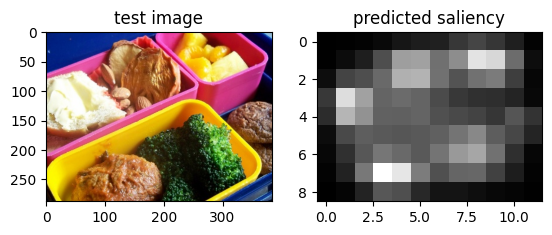

In [22]:
image_idx = 1 # select an image here (1 or 2)
test_img = f"./example/{1}.jpg"

img = preprocess_img(test_img) # padding and resizing input image into 384x288
np_img = img.copy()
np_img = np_img[:, :, ::-1]
img = np.array(img)/255.
img = np.expand_dims(np.transpose(img,(2,0,1)),axis=0)
img = torch.from_numpy(img)
img = img.type(torch.FloatTensor).to(DEVICE)
img = img.squeeze(dim=0)

sal, _ = model.encoder(img.unsqueeze(0))
# print(sal.squeeze().numpy())
sal = sal.view(9, 12).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(np_img)
axes[0].set_title("test image")

axes[1].imshow(sal, cmap='gray')
axes[1].set_title("predicted saliency")

plt.show()

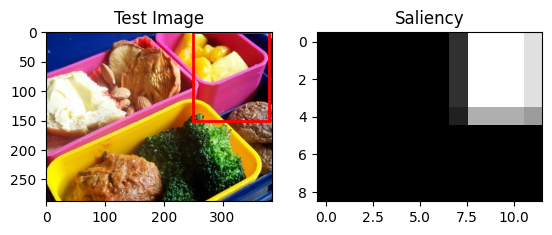

In [24]:
# adjust bounding box here
x = 250
y = 0
w = 130
h = 150
bbx = [x, y, w, h]
blank = False
if bbx == [0, 0, 0, 0]:
    sal = np.zeros((9, 12), dtype=np.uint8)
    sal = torch.from_numpy(sal)
    sal = sal.type(torch.FloatTensor).to(DEVICE)
    sal_n = sal
    blank = True
else:
    sal = get_saliency_map(bbx, DEVICE)
    # print(sal.numpy()[:, y:y+h, x:x+w])
    sal_n = F.avg_pool2d(sal, (32, 32), stride=(32, 32))
    # print(sal_n)
    sal_n = (sal_n - torch.min(sal_n)) / (torch.max(sal_n) - torch.min(sal_n))
    # print(sal_n)
# print(sal_n)
sal_np = sal_n.view(9, 12).numpy()
# print(sal_np)
# Create a Rectangle patch
rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(np_img)
axes[0].add_patch(rect)
axes[0].set_title("Test Image")

axes[1].imshow(sal_np, cmap='gray')
axes[1].set_title("Saliency")

# axes[2].imshow(1 - sal_np, cmap='gray')
# axes[2].set_title("Context")

plt.show()

In [282]:
# run this to generate captions
data_a = list(generate_caption(img))
caption_a, results_a = data_a[0], data_a[1:]
for i in range(4):
    results_a[i] = normalize_list(results_a[i])[1:]
    results_a[i] = [d.item() for d in results_a[i]]

sal_scores_a, ctx_scores_a, e_sals_a, e_ctxs_a, a_maps_a = results_a

a_maps_a = a_maps_a[1:]

_, decoded_captions_a = beam_search(img, k=5)
caption_words_a = caption_a.split()
################################################################
data_b = list(generate_caption(img, sal, blank=blank))
caption_b, results_b = data_b[0], data_b[1:]

for i in range(4):
    results_b[i] = normalize_list(results_b[i])[1:]
    results_b[i] = [d.item() for d in results_b[i]]

sal_scores_b, ctx_scores_b, e_sals_b, e_ctxs_b, a_maps_b = results_b

a_maps_b = a_maps_b[1:]

_, decoded_captions_b = beam_search(img, sal_x=sal, k=5, blank=blank)
caption_words_b = caption_b.split()

print("Predicted saliency map:")
print(caption_a)
for cap in decoded_captions_a:
    print(cap)

print("\nPre-defined saliency map:")
print(caption_b)
for cap in decoded_captions_b:
    print(cap)

Predicted saliency map:
A baseball player swinging a bat on top of a field .
an image of a baseball player getting ready to bat
an image of a baseball player getting ready to swing his bat
an image of a baseball player getting ready to swing a bat
an image of a baseball player getting ready to swing the bat
an image of a baseball player getting ready to swing his baseball bat

Pre-defined saliency map:
A baseball player swinging a bat on top of a field .
there are two baseball players that can be far away
there are two baseball players that can be seen on the field
there are two baseball players that can be seen in the field
there are two baseball players that can be seen in the distance
there are two baseball players that can be far away from the dugout
there are two baseball players that can be far away from the catcher


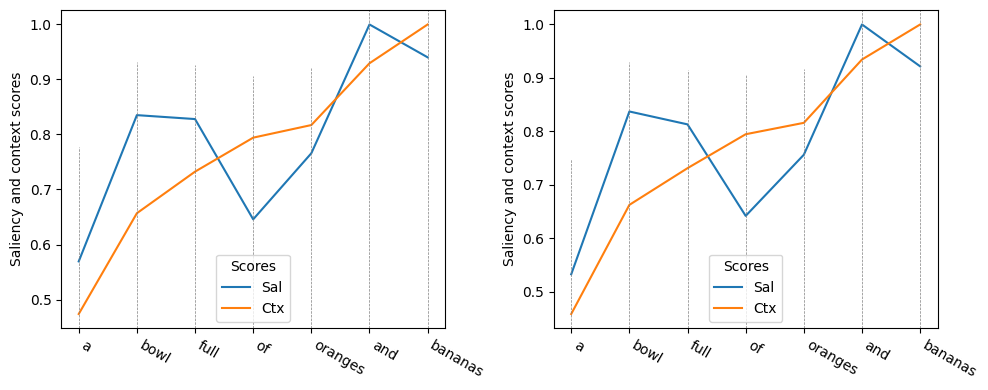

In [255]:
a = e_sals_a
b = e_ctxs_a
c = e_sals_b
d = e_ctxs_b

fig, axes = plt.subplots(nrows=1, ncols=2)

x = range(len(caption_words_a))
axes[0].plot(x, a, label='Sal')
axes[0].plot(x, b, label='Ctx')

for i in x:
    axes[0].axvline(x=i, ymin=0, ymax=max(a[i], b[i]), color='gray', linestyle='--', linewidth=0.5)

axes[0].set_xticks(x)
axes[0].set_xticklabels(caption_words_a, rotation=-30, ha='left')
axes[0].set_ylabel('Saliency and context scores')
axes[0].legend(title='Scores', loc='best')
##################################################################################
x = range(len(caption_words_b))
axes[1].plot(x, c, label='Sal')
axes[1].plot(x, d, label='Ctx')

for i in x:
    axes[1].axvline(x=i, ymin=0, ymax=max(c[i], d[i]), color='gray', linestyle='--', linewidth=0.5)

axes[1].set_xticks(x)
axes[1].set_xticklabels(caption_words_b, rotation=-30, ha='left')
axes[1].set_ylabel('Saliency and context scores')
axes[1].legend(title='Scores', loc='best')

fig.set_size_inches(10, 4)
plt.tight_layout()
plt.show()
plt.close()



In [63]:
def plot_attention(image, result, attention_plot, alpha=0.6):
    temp_image = image
    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    num_cols = min(4, len(result))  # or any other fixed number you prefer
    num_rows = math.ceil(len_result / num_cols)

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(num_rows, num_cols, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=alpha, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


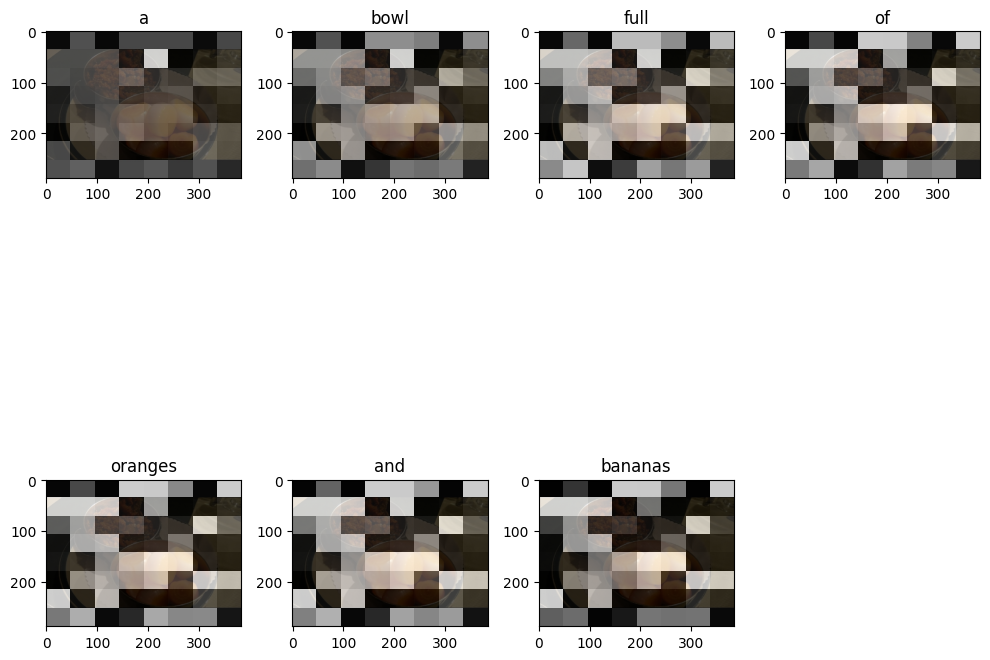

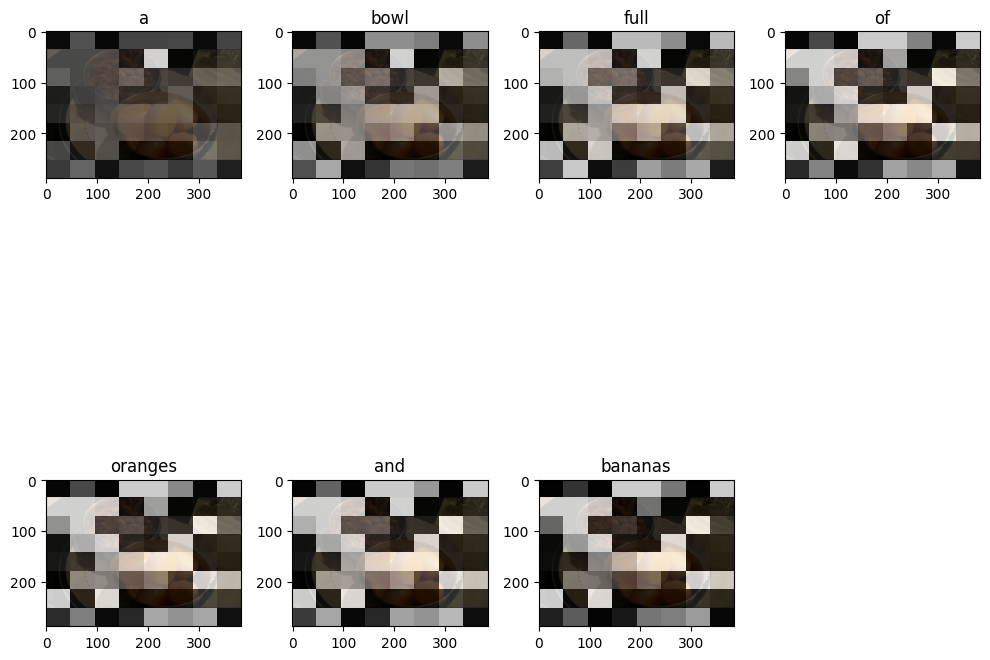

In [256]:
plot_attention(np_img, caption_words_a, a_maps_a, alpha=0.8)
plot_attention(np_img, caption_words_b, a_maps_b, alpha=0.8)